In [2]:
# set deploy needed flag
DEPLOY_NEEDED = False

In [3]:
#install tf to avoid errors
!pip install -q tensorflow==2.11.0 

In [4]:
import tensorflow as tf

2024-07-09 23:01:56.396430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-09 23:01:56.510928: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-09 23:01:56.515042: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-09 23:01:56.515055: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [5]:
# tensor flow import
#import tensorflow as tf
print(tf.__version__) # This notebook runs on TensorFlow 1.15.x or earlier
tf_framework_version = tf.__version__

2.11.0


In [6]:
# Get Session/ Bucket/ Role

In [7]:
# Import session only after installing and importing tensor flow

from sagemaker import get_execution_role
from sagemaker import Session


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [8]:
#other imports
import os
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import model_from_json
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras import utils as kutils

In [9]:
role = get_execution_role()
sess = Session()
bucket = sess.default_bucket()

#### Load the previously trained and saved model (saved in tf format)

In [10]:
local_model_path = 'AR/models/model2/Binary_AvalancheOrNot_ARCNN_1'  # Local path  the model is saved in
loaded_model = tf.keras.models.load_model(local_model_path)

2024-07-09 23:02:06.347620: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-07-09 23:02:06.350893: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-09 23:02:06.350954: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-07-09 23:02:06.350996: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-07-09 23:02:06.351038: W tensorflow/c

In [11]:
# print loaded model signatire
print(list(loaded_model.signatures.keys()))
infer = loaded_model.signatures["serving_default"]
print(infer.structured_outputs)


['serving_default']
{'dense': TensorSpec(shape=(None, 1), dtype=tf.float32, name='dense')}


#### Step 3. Export the Keras model to the TensorFlow ProtoBuf format

******************************************************************************************************

To set up hosting, the first step involves importing the model from training to hosting. This process begins by exporting the model from TensorFlow and saving it to the file system. Additionally, the model needs to be converted into a format compatible with sagemaker.tensorflow.model.TensorFlowModel, which has a slight difference compared to a standard TensorFlow model. However, this conversion is straightforward and involves moving the TensorFlow exported model into a directory named export\Servo\ and compressing the entire directory into a tar file. SageMaker will recognize this compressed file as a loadable TensorFlow model.

In [12]:
loaded_model.save("AR/export/Model2/Servo/1")

INFO:tensorflow:Assets written to: AR/export/Model2/Servo/1/assets


INFO:tensorflow:Assets written to: AR/export/Model2/Servo/1/assets


In [13]:
# tar the entire directory
import tarfile
model_archive = 'AR/ARModel2V1.tar.gz'
with tarfile.open(model_archive, mode='w:gz') as archive:
    archive.add('AR/export/Model2/Servo/1', recursive=True) 


In [14]:
# Now upload the tar file to S3
s3_response = sess.upload_data('AR/ARModel2V1.tar.gz', bucket=bucket, key_prefix="model")


After uploading the model to S3, it can be imported into SageMaker using sagemaker.tensorflow.model.TensorFlowModel for deployment. This step necessitates providing the location of the S3 bucket containing the model and the role for authentication.

In [15]:
import sagemaker.tensorflow.model as smtfmdl

sagemaker_model =  smtfmdl.TensorFlowModel(
    model_data=f"s3://{bucket}/model/ARModel2V1.tar.gz",
    role=role,
    framework_version=tf_framework_version,
)


#### Deploy the model

In [16]:
instance_type = 'ml.g4dn.xlarge' # 0.7364 per hour
#####instance_type = 'ml.t3.medium' # not allowed
instance_type = 'ml.c5.large' # 0.102 per hour

DEPLOY_NEEDED = True
if DEPLOY_NEEDED:
    predictor = sagemaker_model.deploy(initial_instance_count=1, instance_type=instance_type)

----!

******************************************************************************************************

In [41]:
'''
# Export to tf protobuf format

from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants

if tf.executing_eagerly():
   tf.compat.v1.disable_eager_execution()

# Note: This directory structure will need to be followed 
model_version = '1'
export_dir = 'AR/export/Servo/' + model_version

# Build the Protocol Buffer SavedModel at path defined by export_dir variable
#builder = builder.SavedModelBuilder(export_dir)
builder = tf.compat.v1.saved_model.Builder(export_dir)

# Create prediction signature to be used by TensorFlow Serving Predict API
signature = predict_signature_def(
    inputs={"inputs": loaded_model.input}, outputs={"score": loaded_model.output})

# Save the meta graph and variables
builder.add_meta_graph_and_variables(
    sess=K.get_session(), tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
builder.save()
'''

In [74]:
'''
# Note: This directory structure will need to be followed 
model_version = '4'
export_dir = 'AR/export/Servo/' + model_version
loaded_model.compile
loaded_model.save(export_dir)
'''

#### Display the model details

In [75]:
'''
model_path = 'AR/export/Servo/4'
!saved_model_cli show --all --dir {model_path}
'''

#### Tar the entire directory and upload to S3

In [78]:
'''
# tar the entire directory
import tarfile
model_archive = 'AR/ARModel1V4.tar.gz'
with tarfile.open(model_archive, mode='w:gz') as archive:
    archive.add('AR/export/Servo/4', recursive=True) 

# upload model artifacts to S3
model_data = sess.upload_data(path=model_archive, key_prefix='model')
'''

#### Deploy to Sagemaker Endpoint

In [80]:
'''
#from sagemaker.tensorflow.serving import Model
import sagemaker.tensorflow.model as tfm

#sagemaker.tensorflow.model.TensorFlowModel


# Select which type of SageMaker EC2 instance to deploy the model on  
instance_type = 'ml.g4dn.xlarge' 

# Instantiate the SageMaker TensorFlow serving model  
#sm_model = Model(model_data=model_data, 
#                 framework_version=tf_framework_version,
#                 role=role)

sagemaker_model = tfm.TensorFlowModel(
    model_data=model_data,
    role=role,
    framework_version=tf_framework_version
)

'''

In [82]:
'''
DEPLOY_NEEDED = True
if DEPLOY_NEEDED:
    compiled_predictor = sm_model.deploy(initial_instance_count=1, instance_type=instance_type)
'''

### Predict from the endpoint

In [17]:
# Local Directory paths
local_directory = 'AR/images/local_image_directory'
local_train = os.path.join(local_directory, 'train')
local_val =  os.path.join(local_directory, 'val')
local_test =  os.path.join(local_directory, 'test')

1/1 [==============================] - 0s 329ms/step


2024-07-09 23:07:02.802469: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/add_2/add' exist for missing node 'model/add_1/add'.
2024-07-09 23:07:02.829054: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'model/add_2/add' exist for missing node 'model/add_1/add'.


[[0.52658355]]
62.87% Avalanche.


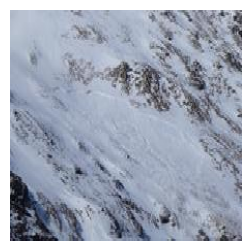

1/1 [==============================] - 0s 77ms/step
[[-0.05718519]]
48.57% Avalanche.


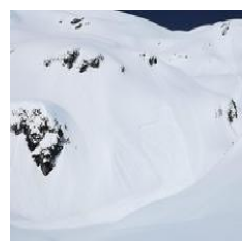

1/1 [==============================] - 0s 83ms/step
[[0.3084661]]
57.65% Avalanche.


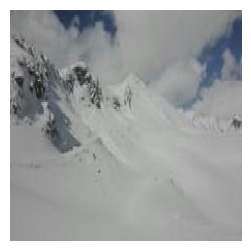

1/1 [==============================] - 0s 93ms/step
[[1.1753777]]
76.41% Avalanche.


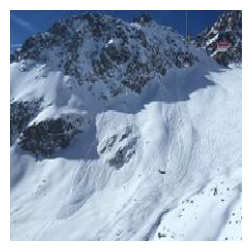

1/1 [==============================] - 0s 72ms/step
[[0.78582686]]
68.69% Avalanche.


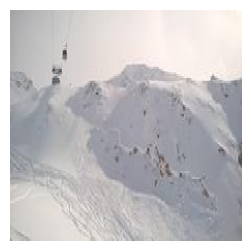

In [18]:

# OPTION 1 : USe the loaded model in memory and infer
# ****** This code works ********

local_directory = 'AR/images/local_image_directory'

local_train = os.path.join(local_directory, 'train')
local_val =  os.path.join(local_directory, 'val')
local_test =  os.path.join(local_directory, 'test')


i=0
LIMIT = 5
directory = local_test + "/positive"
image_size = (224,224)


for filename in os.listdir(directory):
    i=i+1
    if i> LIMIT:
        break
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        img = kutils.load_img(f, target_size=image_size)
        img_array = kutils.img_to_array(img)
        img_array = np.expand_dims(img_array, 0)  # Create batch axis
        body = img_array
        #body = json.dumps({"instances": img_array.tolist()})
        
        predictions = loaded_model.predict(body)
        print(predictions) 
        prediction_score_raw = predictions[0,0]
        prediction_score = 1/(1+np.exp(-prediction_score_raw) )

        print(f"{100 * prediction_score:.2f}% Avalanche.")

        # Plot the image
        plt.figure(figsize=(6, 3))
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        plt.show()

        

In [19]:
from sagemaker.predictor import Predictor
import json

import sagemaker.serializers

73.88% Avalanche.


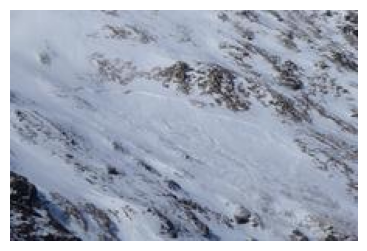

46.01% Avalanche.


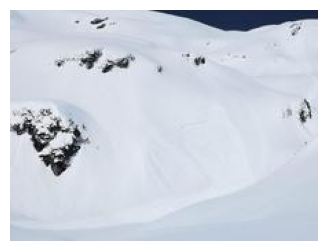

63.98% Avalanche.


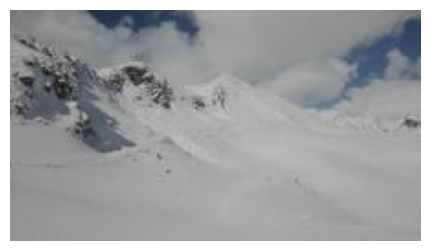

66.50% Avalanche.


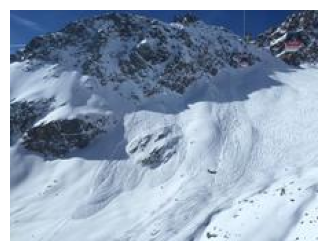

58.81% Avalanche.


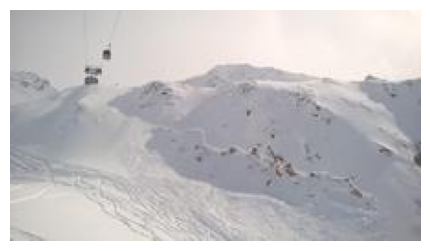

In [20]:

# OPTION 2 : USe the Sagemaker Endpoint and infer
# ****** This code DOES NOT work ********

import numpy as np
from PIL import Image
import io


sagemaker_session = sagemaker.Session()

# Local Directory paths



local_directory = 'AR/images/local_image_directory'

local_train = os.path.join(local_directory, 'train')
local_val =  os.path.join(local_directory, 'val')
local_test =  os.path.join(local_directory, 'test')


endpoint_name = 'tensorflow-inference-2024-07-09-23-03-50-475'

predictor = sagemaker.predictor.Predictor(endpoint_name = endpoint_name, sagemaker_session=sagemaker_session)
predictor.serializer = sagemaker.serializers.JSONSerializer()
##print(predictor)


i=0
LIMIT = 5
directory = local_test + "/positive"
image_size = (224,224)


for filename in os.listdir(directory):
    i=i+1
    if i> LIMIT:
        break
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        

        # Load the image
        img = Image.open(f)
        # Resize the image while maintaining the aspect ratio
        img.thumbnail(image_size)
        # Convert the image to a byte array
        #img_byte_array = io.BytesIO()
        img_byte_array = np.expand_dims(img, 0)  # Create batch axis
        
        ###img = kutils.load_img(f, target_size=image_size)
        ###img_array = np.asarray(img) ####kutils.img_to_array(img)
        ###img_array = np.expand_dims(img_array, 0)  # Create batch axis
        ###print(str(img_array.tolist())[:200])
        #body = json.dumps({"instances": img_array.tolist()})
        ###print(img_array.shape)
        ###body = json.dumps(img_array.tolist())
        body = img_byte_array
        ###print(str(body[:200]))
        
 

        inference_response = predictor.predict(data=body)
        #print(inference_response)
        predictions = a = json.loads(inference_response)
         
        #print(predictions) 
        #print(list(predictions["predictions"])[0][0]) 
        
        
        prediction_score_raw = list(predictions["predictions"])[0][0]
        prediction_score = 1/(1+np.exp(-prediction_score_raw) )

        print(f"{100 * prediction_score:.2f}% Avalanche.")

        # Plot the image
        plt.figure(figsize=(6, 3))
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        plt.show()

        

72.46% Avalanche.


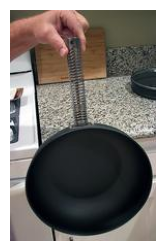

90.74% Avalanche.


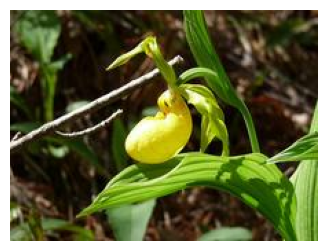

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) from primary with message "{
    "error": "convolution input must be 4-dimensional: [1,168,224]\n\t [[{{function_node __inference__wrapped_model_6336}}{{node model/conv2d/BiasAdd}}]]"
}". See https://us-west-1.console.aws.amazon.com/cloudwatch/home?region=us-west-1#logEventViewer:group=/aws/sagemaker/Endpoints/tensorflow-inference-2024-07-09-23-03-50-475 in account 411437553757 for more information.

In [22]:

# OPTION 3 : USe the Sagemaker Endpoint Using BOTO3 and infer
# ****** This code DOES NOT work ********


from PIL import Image
import numpy as np
import json
import boto3


# Local Directory paths
local_directory = 'AR/images/local_image_directory'
local_train = os.path.join(local_directory, 'train')
local_val =  os.path.join(local_directory, 'val')
local_test =  os.path.join(local_directory, 'test')


endpoint_name = 'tensorflow-inference-2024-07-09-23-03-50-475'

client = boto3.client('sagemaker-runtime') 

i=0
LIMIT = 5
directory = local_test + "/negative"
image_size = (224,224)


for filename in os.listdir(directory):
    i=i+1
    if i> LIMIT:
        break
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        
        # Load the image
        img = Image.open(f)
        # Resize the image while maintaining the aspect ratio
        img.thumbnail(image_size)
        # Convert the image to a byte array
        img_byte_array = np.expand_dims(img, 0)  # Create batch axis
        body = json.dumps(img_byte_array.tolist())
        content_type = 'application/json'   
        ioc_response = client.invoke_endpoint(
            EndpointName=endpoint_name,
            Body=body,
            ContentType=content_type,
             
         )
        response = json.loads(ioc_response['Body'].read())
        prediction_score_raw = list(response["predictions"])[0][0]
        prediction_score = 1/(1+np.exp(-prediction_score_raw) )

        print(f"{100 * prediction_score:.2f}% Avalanche.")

        # Plot the image
        plt.figure(figsize=(6, 3))
        plt.imshow(img)
        plt.axis('off')  # Hide the axis
        plt.show()

        